## This is a FSI problem of 2D cylinder falling in a quiescent flow

Considering the fictitious fluid inside the cylinder due to immersed boundary method, also considering buoyancy.

To keep consistency between *Dyn3d* and *ViscousFlow*, the cylinder is setup in z-x coordinates, so gravity should also be set in z direction

In [1]:
using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "FallingCylinder";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 2.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,1.0,0.0,9.2], zeros(Float64,6), 0, [dofₚ], [0.0])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 1.0, 0.0, 9.2]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [5]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [6]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [7]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [8]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

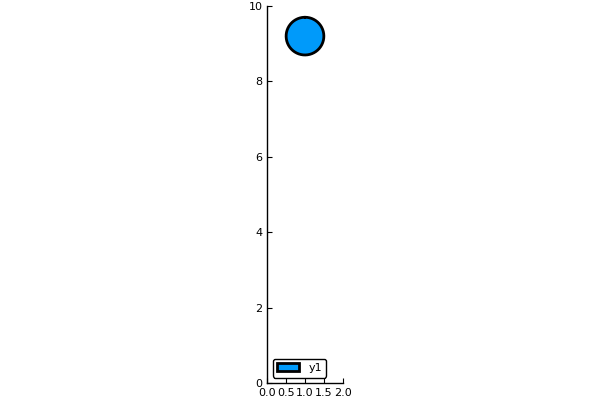

In [9]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,2), ylims=(0,10),ratio=1)
# plot!(xlims=(0,2), ylims=(0,3),ratio=1)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [10]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [11]:
nx = 102; ny = 502;
Ly = 10.0;
# nx = 102; ny = 152;
# Ly = 3.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:10.01)

#### Set up fluid initial conditions

In [12]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [13]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [14]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [15]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [16]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [17]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

In [18]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), bd -> F(bd,config_body.ρ), w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=2, ρb=config_body.ρ)

 16.765213 seconds (58.95 M allocations: 4.473 GiB, 4.86% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [19]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [20]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
    if mod(round(Int,ti/Δt),200) == 1  
        @save filename*".bson" bd bdhist xg yg whist thist fx fy Δt w qJ v
        println("data saved at time ", ti)
    end
end

 15.271068 seconds (48.12 M allocations: 3.983 GiB, 4.30% gc time)
next time unit is 0.01
data saved at time 0.01
 11.621252 seconds (38.04 M allocations: 3.505 GiB, 2.94% gc time)
next time unit is 0.02
 11.586283 seconds (38.04 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 0.03
 12.279257 seconds (38.04 M allocations: 3.505 GiB, 3.81% gc time)
next time unit is 0.04
 12.433895 seconds (38.04 M allocations: 3.505 GiB, 2.90% gc time)
next time unit is 0.05
 12.285573 seconds (38.04 M allocations: 3.505 GiB, 2.92% gc time)
next time unit is 0.06
 12.649117 seconds (38.04 M allocations: 3.505 GiB, 3.71% gc time)
next time unit is 0.07
 11.633723 seconds (38.04 M allocations: 3.505 GiB, 2.91% gc time)
next time unit is 0.08
 11.591517 seconds (38.04 M allocations: 3.505 GiB, 2.90% gc time)
next time unit is 0.09
 11.757411 seconds (38.04 M allocations: 3.505 GiB, 2.94% gc time)
next time unit is 0.1
 12.287946 seconds (38.04 M allocations: 3.505 GiB, 3.66% gc time)
next time 

 15.190092 seconds (38.04 M allocations: 3.505 GiB, 2.77% gc time)
next time unit is 0.92
 16.062359 seconds (38.04 M allocations: 3.505 GiB, 2.71% gc time)
next time unit is 0.93
 15.724495 seconds (38.04 M allocations: 3.505 GiB, 2.89% gc time)
next time unit is 0.94
 15.975994 seconds (38.04 M allocations: 3.505 GiB, 3.68% gc time)
next time unit is 0.95
 15.631968 seconds (38.04 M allocations: 3.505 GiB, 2.77% gc time)
next time unit is 0.96
 16.798152 seconds (38.04 M allocations: 3.505 GiB, 2.69% gc time)
next time unit is 0.97
 15.026487 seconds (38.04 M allocations: 3.505 GiB, 3.59% gc time)
next time unit is 0.98
 14.604280 seconds (38.04 M allocations: 3.505 GiB, 2.85% gc time)
next time unit is 0.99
 13.162605 seconds (38.04 M allocations: 3.505 GiB, 2.90% gc time)
next time unit is 1.0
 13.328113 seconds (38.04 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 1.01
 14.441399 seconds (38.04 M allocations: 3.505 GiB, 3.55% gc time)
next time unit is 1.02
 13.244621 

 13.102883 seconds (38.01 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 1.84
 13.035172 seconds (38.01 M allocations: 3.505 GiB, 3.66% gc time)
next time unit is 1.85
 12.446667 seconds (38.01 M allocations: 3.505 GiB, 2.91% gc time)
next time unit is 1.86
 12.442624 seconds (38.01 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 1.87
 12.361543 seconds (38.01 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 1.88
 12.503050 seconds (38.01 M allocations: 3.505 GiB, 3.78% gc time)
next time unit is 1.89
 12.599350 seconds (38.01 M allocations: 3.505 GiB, 2.93% gc time)
next time unit is 1.9
 12.419291 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 1.91
 12.659457 seconds (38.01 M allocations: 3.505 GiB, 3.74% gc time)
next time unit is 1.92
 12.410922 seconds (38.01 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 1.93
 12.456617 seconds (38.01 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 1.94
 12.762453 

 12.138636 seconds (38.01 M allocations: 3.505 GiB, 2.97% gc time)
next time unit is 2.75
 12.179909 seconds (38.01 M allocations: 3.505 GiB, 2.97% gc time)
next time unit is 2.76
 12.274254 seconds (38.01 M allocations: 3.505 GiB, 3.80% gc time)
next time unit is 2.77
 12.147935 seconds (38.01 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 2.78
 12.242586 seconds (38.01 M allocations: 3.504 GiB, 2.94% gc time)
next time unit is 2.79
 12.245522 seconds (38.01 M allocations: 3.505 GiB, 3.05% gc time)
next time unit is 2.8
 12.289656 seconds (38.01 M allocations: 3.505 GiB, 3.73% gc time)
next time unit is 2.81
 12.429940 seconds (38.01 M allocations: 3.505 GiB, 2.97% gc time)
next time unit is 2.82
 12.241951 seconds (38.01 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 2.83
 12.296534 seconds (38.01 M allocations: 3.505 GiB, 3.80% gc time)
next time unit is 2.84
 12.169881 seconds (38.01 M allocations: 3.505 GiB, 2.92% gc time)
next time unit is 2.85
 12.175290 

 13.074196 seconds (38.01 M allocations: 3.505 GiB, 3.78% gc time)
next time unit is 3.67
 12.966003 seconds (38.01 M allocations: 3.505 GiB, 3.02% gc time)
next time unit is 3.68
 13.057533 seconds (38.01 M allocations: 3.505 GiB, 2.94% gc time)
next time unit is 3.69
 12.967605 seconds (38.01 M allocations: 3.505 GiB, 3.74% gc time)
next time unit is 3.7
 13.157962 seconds (38.02 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 3.71
 13.067167 seconds (38.01 M allocations: 3.505 GiB, 2.90% gc time)
next time unit is 3.72
 12.934542 seconds (38.03 M allocations: 3.505 GiB, 2.92% gc time)
next time unit is 3.73
 13.199389 seconds (38.01 M allocations: 3.505 GiB, 3.66% gc time)
next time unit is 3.74
 13.069868 seconds (38.01 M allocations: 3.505 GiB, 2.93% gc time)
next time unit is 3.75
 13.046535 seconds (38.02 M allocations: 3.505 GiB, 3.01% gc time)
next time unit is 3.76
 13.200229 seconds (38.01 M allocations: 3.505 GiB, 3.80% gc time)
next time unit is 3.77
 13.010342 

 11.451934 seconds (38.01 M allocations: 3.504 GiB, 2.98% gc time)
next time unit is 4.58
 11.445658 seconds (38.01 M allocations: 3.504 GiB, 2.99% gc time)
next time unit is 4.59
 11.450463 seconds (38.01 M allocations: 3.504 GiB, 3.01% gc time)
next time unit is 4.6
 11.598576 seconds (38.01 M allocations: 3.504 GiB, 3.72% gc time)
next time unit is 4.61
 11.439524 seconds (38.01 M allocations: 3.504 GiB, 3.00% gc time)
next time unit is 4.62
 11.452919 seconds (38.01 M allocations: 3.504 GiB, 3.01% gc time)
next time unit is 4.63
 11.614098 seconds (38.01 M allocations: 3.504 GiB, 3.76% gc time)
next time unit is 4.64
 11.443678 seconds (38.01 M allocations: 3.504 GiB, 2.95% gc time)
next time unit is 4.65
 11.433557 seconds (38.01 M allocations: 3.504 GiB, 3.00% gc time)
next time unit is 4.66
 11.543575 seconds (38.01 M allocations: 3.504 GiB, 3.75% gc time)
next time unit is 4.67
 11.458648 seconds (38.01 M allocations: 3.504 GiB, 2.97% gc time)
next time unit is 4.68
 11.450430 

 11.443926 seconds (38.01 M allocations: 3.505 GiB, 3.02% gc time)
next time unit is 5.5
 11.552425 seconds (38.01 M allocations: 3.505 GiB, 3.76% gc time)
next time unit is 5.51
 11.449259 seconds (38.01 M allocations: 3.505 GiB, 2.98% gc time)
next time unit is 5.52
 11.458129 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 5.53
 11.530644 seconds (38.01 M allocations: 3.505 GiB, 3.77% gc time)
next time unit is 5.54
 11.448761 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 5.55
 11.448080 seconds (38.01 M allocations: 3.505 GiB, 3.00% gc time)
next time unit is 5.56
 11.439070 seconds (38.01 M allocations: 3.505 GiB, 3.00% gc time)
next time unit is 5.57
 11.614293 seconds (38.01 M allocations: 3.505 GiB, 3.75% gc time)
next time unit is 5.58
 11.449691 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 5.59
 11.464839 seconds (38.01 M allocations: 3.505 GiB, 3.01% gc time)
next time unit is 5.6
 11.551835 s

 11.658482 seconds (38.01 M allocations: 3.505 GiB, 2.98% gc time)
next time unit is 6.41
 11.704119 seconds (38.01 M allocations: 3.505 GiB, 3.00% gc time)
next time unit is 6.42
 11.784371 seconds (38.01 M allocations: 3.504 GiB, 3.78% gc time)
next time unit is 6.43
 11.677459 seconds (38.01 M allocations: 3.504 GiB, 3.00% gc time)
next time unit is 6.44
 11.788489 seconds (38.01 M allocations: 3.505 GiB, 2.96% gc time)
next time unit is 6.45
 11.699982 seconds (38.01 M allocations: 3.505 GiB, 3.79% gc time)
next time unit is 6.46
 11.673232 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 6.47
 11.779338 seconds (38.01 M allocations: 3.505 GiB, 3.01% gc time)
next time unit is 6.48
 11.649253 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 6.49
 11.789415 seconds (38.01 M allocations: 3.505 GiB, 3.77% gc time)
next time unit is 6.5
 11.675935 seconds (38.01 M allocations: 3.505 GiB, 2.99% gc time)
next time unit is 6.51
 11.708457 

 11.935843 seconds (38.01 M allocations: 3.504 GiB, 3.85% gc time)
next time unit is 7.33
 11.663659 seconds (38.01 M allocations: 3.504 GiB, 3.02% gc time)
next time unit is 7.34
 11.996913 seconds (38.01 M allocations: 3.504 GiB, 3.01% gc time)
next time unit is 7.35
 12.193630 seconds (38.01 M allocations: 3.505 GiB, 3.82% gc time)
next time unit is 7.36
 12.751725 seconds (38.01 M allocations: 3.505 GiB, 2.95% gc time)
next time unit is 7.37
 11.817619 seconds (38.01 M allocations: 3.505 GiB, 3.01% gc time)
next time unit is 7.38
 12.077517 seconds (38.01 M allocations: 3.505 GiB, 3.00% gc time)
next time unit is 7.39
 11.864983 seconds (38.01 M allocations: 3.505 GiB, 3.80% gc time)
next time unit is 7.4
 11.563559 seconds (38.01 M allocations: 3.505 GiB, 3.00% gc time)
next time unit is 7.41
 11.502461 seconds (38.01 M allocations: 3.504 GiB, 3.04% gc time)
next time unit is 7.42
 11.619750 seconds (38.01 M allocations: 3.504 GiB, 3.79% gc time)
next time unit is 7.43
 11.478835 

 11.513183 seconds (38.01 M allocations: 3.505 GiB, 3.05% gc time)
next time unit is 8.24
 11.526763 seconds (38.01 M allocations: 3.504 GiB, 3.06% gc time)
next time unit is 8.25
 11.617662 seconds (38.01 M allocations: 3.504 GiB, 3.83% gc time)
next time unit is 8.26
 11.528235 seconds (38.01 M allocations: 3.505 GiB, 3.05% gc time)
next time unit is 8.27
 11.505983 seconds (38.01 M allocations: 3.505 GiB, 3.08% gc time)
next time unit is 8.28
 11.655290 seconds (38.01 M allocations: 3.505 GiB, 3.80% gc time)
next time unit is 8.29
 11.508255 seconds (38.01 M allocations: 3.505 GiB, 3.05% gc time)
next time unit is 8.3
 11.510158 seconds (38.01 M allocations: 3.504 GiB, 3.06% gc time)
next time unit is 8.31
 11.506361 seconds (38.01 M allocations: 3.504 GiB, 3.07% gc time)
next time unit is 8.32
 11.618515 seconds (38.01 M allocations: 3.505 GiB, 3.84% gc time)
next time unit is 8.33
 11.536721 seconds (38.01 M allocations: 3.505 GiB, 3.04% gc time)
next time unit is 8.34
 11.514990 

 11.518948 seconds (38.01 M allocations: 3.504 GiB, 3.06% gc time)
next time unit is 9.16
 11.527902 seconds (38.01 M allocations: 3.504 GiB, 3.04% gc time)
next time unit is 9.17
 11.530306 seconds (38.01 M allocations: 3.505 GiB, 3.07% gc time)
next time unit is 9.18
 11.644144 seconds (38.01 M allocations: 3.504 GiB, 3.84% gc time)
next time unit is 9.19
 11.560934 seconds (38.01 M allocations: 3.504 GiB, 3.07% gc time)
next time unit is 9.2
 11.515047 seconds (38.01 M allocations: 3.504 GiB, 3.03% gc time)
next time unit is 9.21
 11.637778 seconds (38.01 M allocations: 3.505 GiB, 3.85% gc time)
next time unit is 9.22
 11.581097 seconds (38.01 M allocations: 3.505 GiB, 3.06% gc time)
next time unit is 9.23
 11.522545 seconds (38.01 M allocations: 3.505 GiB, 3.06% gc time)
next time unit is 9.24
 11.515808 seconds (38.01 M allocations: 3.505 GiB, 3.05% gc time)
next time unit is 9.25
 11.738586 seconds (38.01 M allocations: 3.504 GiB, 3.81% gc time)
next time unit is 9.26
 11.525854 

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [21]:
contour_levels = range(minimum(w.data),stop=maximum(w.data),length=40)
sample_freq = 5
fps = 25;

#### Get body verts history

In [22]:
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

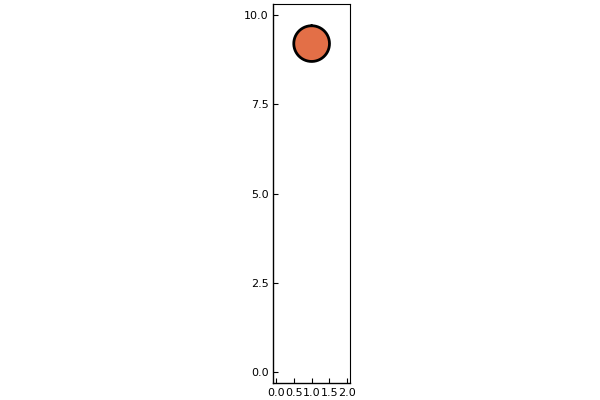

In [23]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

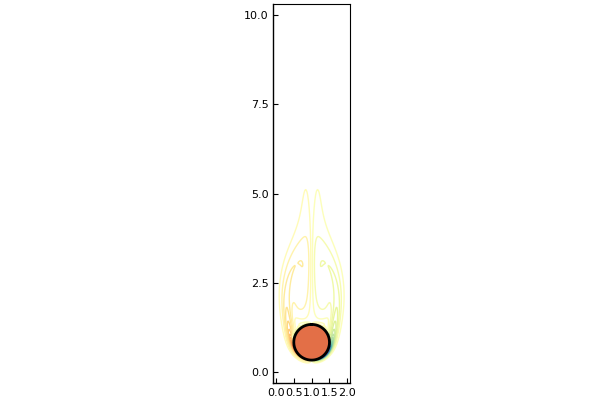

In [24]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

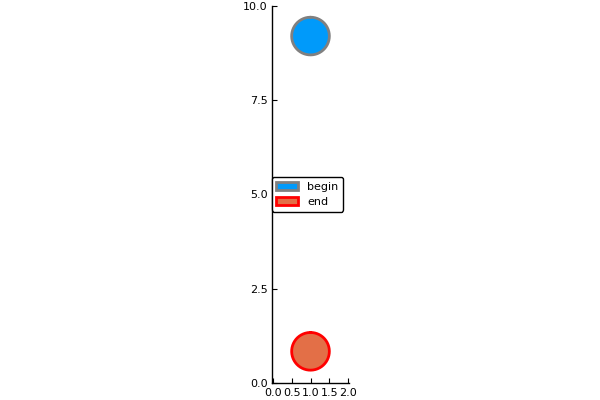

In [25]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make gif

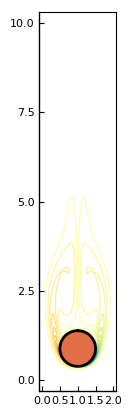

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/FallingCylinder.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/FallingCylinder.gif")

In [26]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,1], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black",fill=true)
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [27]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

#### Plot cylinder position, velocity, acceleration

In [28]:
# pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,ylims=(-25,0))
# pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,ylims=(-2,0))
# pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,ylims=(-0.5,0))

# plot(pp,pv,pa)

In [29]:
ahist[1:3]

3-element Array{Any,1}:
 -0.31736944424872987
 -0.3153319298370376 
 -0.31358066800364937

In [30]:
using CSV

pdata = CSV.read("local_run/validation/csv/position.csv",header=false)
xp = [pdata[i,1] for i in 1:length(pdata[1])]
yp = [pdata[i,2] for i in 1:length(pdata[2])]

vdata = CSV.read("local_run/validation/csv/velocity.csv",header=false)
xv = [vdata[i,1] for i in 1:length(vdata[1])]
yv = [vdata[i,2] for i in 1:length(vdata[2])]

adata = CSV.read("local_run/validation/csv/acceleration.csv",header=false)
xa = [adata[i,1] for i in 1:length(adata[1])]
ya = [adata[i,2] for i in 1:length(adata[2])];

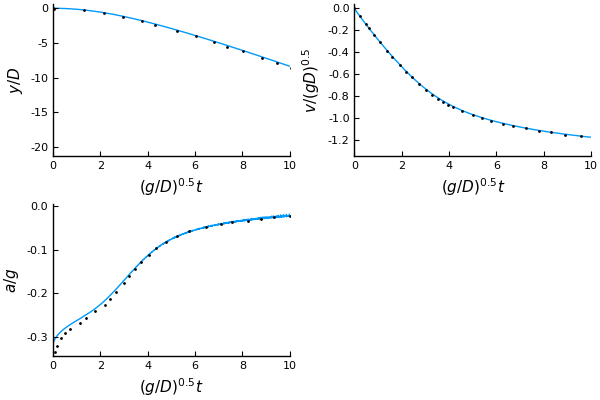

In [31]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,xlims=(0,10.0))
scatter!(pp,xp,yp,linestyle=:dot,markersize=1)
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,xlims=(0,10.0))
scatter!(xv,yv,linestyle=:dot,markersize=1)
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,xlims=(0,10.0))
scatter!(xa,ya,linestyle=:dot,markersize=1)

plot(pp,pv,pa)

#### Lift and drag coefficients

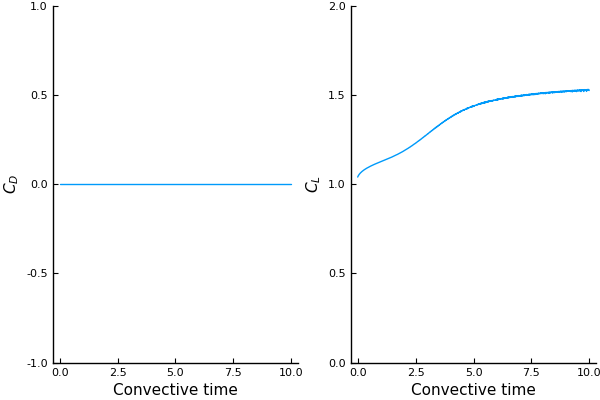

In [32]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [33]:
@save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [34]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);